## **Installation**

In [1]:
!python -m pip install pyyaml==5.1

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import sys, os, distutils.core

In [3]:
# !git clone 'https://github.com/facebookresearch/detectron2.git'

In [4]:
dist = distutils.core.run_setup("detectron2/setup.py")

In [5]:
dist.install_requires

['Pillow>=7.1',
 'matplotlib',
 'pycocotools>=2.0.2',
 'termcolor>=1.1',
 'yacs>=0.1.8',
 'tabulate',
 'cloudpickle',
 'tqdm>4.29.0',
 'tensorboard',
 'fvcore<0.1.6,>=0.1.5',
 'iopath<0.1.10,>=0.1.7',
 'dataclasses; python_version < "3.7"',
 'omegaconf<2.4,>=2.1',
 'hydra-core>=1.1',
 'black',
 'packaging']

In [6]:
!python -m pip install Pillow>=7.1

In [7]:
!python -m pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [8]:
# !pip list

In [9]:
!python -m pip install pycocotools>=2.0.2 termcolor>=1.1 yacs>=0.1.8 tabulate cloudpickle tqdm>4.29.0 tensorboard

In [10]:
!python -m pip install fvcore<0.1.6,>=0.1.5 

The system cannot find the file specified.


In [11]:
!python -m pip install iopath<0.1.10,>=0.1.7 dataclasses; python_version < "3.7" omegaconf<2.4,>=2.1 hydra-core>=1.1 black packaging

The system cannot find the file specified.


In [12]:
sys.path.insert(0, os.path.abspath('./detectron2'))

## **Importing libraries**

In [13]:
import torch, detectron2
#nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  2.0 ; cuda:  cpu
detectron2: 0.6


In [14]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

matplotlib data path: C:\Users\Prakhar Jadaun\AppData\Roaming\Python\Python311\site-packages\matplotlib\mpl-data
CONFIGDIR=C:\Users\Prakhar Jadaun\.matplotlib
interactive is False
platform is win32
CACHEDIR=C:\Users\Prakhar Jadaun\.matplotlib
Using fontManager instance from C:\Users\Prakhar Jadaun\.matplotlib\fontlist-v330.json


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
from detectron2.structures import BoxMode

In [16]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode

## **Registering the dataset**

In [17]:
def get_sign_dicts(directory):
    classes = ['wind turbine', 'damaged wind turbine']
    dataset_dicts = []
    img_id = 0
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            # print('opened file')
            img_anns = json.load(f)
            # print(img_anns['images'])
            # print(img_anns['file_name'])

        record = {}
        temp = img_anns['imagePath'].split('\\')
    # print(temp[-1])
        filename = os.path.join(directory, temp[-1])
        # filename = os.path.join(directory, img_anns["imagePath"])

        record["file_name"] = filename
        record["image_id"] = img_id
        record["height"] = img_anns["imageHeight"]
        record["width"] = img_anns["imageWidth"]

        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
        img_id += 1
    return dataset_dicts


In [18]:
for file in os.listdir('wind_turbine_dataset/train'):
    # print(file)
    if file.endswith('.json'):
        print(file)
        break

img102.json


In [19]:
for d in ["train", "val"]:
    DatasetCatalog.register("wind_turbine_test2_" + d, lambda d=d: get_sign_dicts('wind_turbine_dataset/' + d))
    MetadataCatalog.get("wind_turbine_test2_" + d).set(thing_classes=['wind turbine','damaged wind turbine'])
wind_turbine_test1_metadata = MetadataCatalog.get("wind_turbine_test2_train")
# print(wind_turbine_test1_metadata)

In [20]:
print(wind_turbine_test1_metadata)

Metadata(name='wind_turbine_test2_train', thing_classes=['wind turbine', 'damaged wind turbine'])


## **Reading the model**

In [26]:
cfg = get_cfg()
cfg.OUTPUT_DIR = 'model/'
cfg.merge_from_file("config.yml")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.DATASETS.TEST = ('wind_turbine_test1_test',)
cfg.DATASETS.TRAIN = ("wind_turbine_test1_train",)

In [27]:
cfg.MODEL.DEVICE = "cpu"

In [28]:
predictor = DefaultPredictor(cfg)

[12/29 23:40:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\model.pth ...
[Checkpointer] Loading from ./output\model.pth ...


In [29]:
img = cv2.imread(r'wind_turbine_dataset\train\img138.png')
# plt.imshow(img)
# plt.show()

# Get the shape of the image
height, width, channels = img.shape

# Check if the image has 3 channels (indicating color)
if channels == 3:
    if img[0, 0, 0] == img[0, 0, 2]:
        print("Image format: BGR")
    else:
        print("Image format: RGB")

Image format: RGB


In [30]:
outputs = predictor(img)

C:\Users\Prakhar Jadaun\AppData\Roaming\Python\Python311\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='C:\\Users\\Prakhar Jadaun\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='C:\\Users\\Prakhar Jadaun\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Users\\Prakhar Jadaun\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Users\\Prak

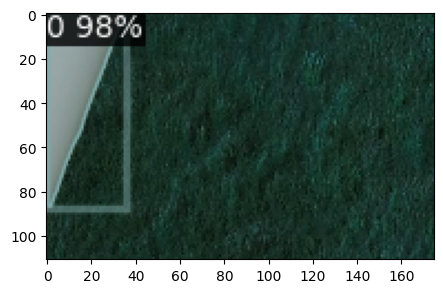

In [31]:
v = Visualizer(cv2.cvtColor(img, cv2.COLOR_RGB2BGR),MetadataCatalog.get('wind_turbine_test1_train' ),scale=0.3)
out = v.draw_instance_predictions(outputs['instances'].to("cpu"))
plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(out.get_image(),cv2.COLOR_BGR2RGB))
plt.show()